In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/group3/dataset/dataframe_hrv.csv
/kaggle/input/group3/dataset/dataset_overview.html
/kaggle/input/group3/dataset/Vikings/Female_24_years_old/intraday_fitbit.csv
/kaggle/input/group3/dataset/Vikings/Female_24_years_old/dfnewHRV.csv
/kaggle/input/group3/dataset/Vikings/Female_24_years_old/2017-12-09 12-47-55.txt
/kaggle/input/group3/dataset/Vikings/Female_24_years_old/Female_24_years_old_vikings.png
/kaggle/input/group3/dataset/Vikings/Female_24_years_old/Female_24_years_old_vikings_annotated.png
/kaggle/input/group3/dataset/Vikings/male_22years/male_22years_vikings.png
/kaggle/input/group3/dataset/Vikings/male_22years/dfnewHRVVIKINGSFULLSERIES.csv
/kaggle/input/group3/dataset/Vikings/male_22years/male_22years_vikings_annotated.png
/kaggle/input/group3/dataset/Vikings/Female_33_years_old/dfnewHRV_Female_33_years_old_vikings.csv
/kaggle/input/group3/dataset/Vikings/Female_33_years_old/Female_33_years_old_vikings_annotated.png
/kaggle/input/group3/dataset/Vikings/Female_33_ye

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV 
from tpot import TPOTClassifier
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal 
import pickle


import sklearn.metrics
from sklearn.model_selection import cross_val_score
from sklearn import svm
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


In [3]:
#loading dataset
dataframe_hrv = pd.read_csv("../input/group3/dataset/dataframe_hrv.csv")
dataframe_hrv = dataframe_hrv.reset_index(drop=True)

In [4]:
#display upto mentioned limit
display(dataframe_hrv.head(5))

,ECG,EMG,HR,RESP,Seconds,footGSR,handGSR,interval in seconds,marker,newtime,stress,time,NNRR,AVNN,SDNN,RMSSD,pNN50,TP,ULF,VLF,LF,HF,LF_HF
0,-0.001974,-0.004737,77.815789,10.801842,12.529684,2.417132,10.889447,0.614632,NaN,12.529684,0.0,12.529684,0.973684,0.617297,3.558630e-02,0.015203,0.055556,0.001238,0.0,0.000696,0.000407,0.000135,3.00200
1,0.002935,-0.004457,101.978261,10.750609,30.503500,2.417109,11.251065,0.647826,NaN,30.503500,0.0,30.503500,0.978261,0.647889,1.354660e-02,0.013858,0.045455,0.000144,0.0,0.000009,0.000060,0.000075,0.79371
2,0.006745,-0.003426,104.957447,10.557234,52.523021,2.226872,11.379638,0.646383,NaN,52.523021,0.0,52.523021,0.978723,0.645000,2.240000e-08,0.000000,0.000000,NaN,0.0,NaN,NaN,NaN,NaN
3,-0.004043,-0.002532,87.702128,10.640128,74.402170,2.173021,11.470830,0.645000,NaN,74.402170,0.0,74.402170,0.978723,0.645000,2.240000e-08,0.000000,0.000000,NaN,0.0,NaN,NaN,NaN,NaN
4,0.012745,-0.004426,88.829787,10.699319,96.219617,2.017106,11.135255,0.645000,NaN,96.219617,0.0,96.219617,0.978723,0.645000,2.240000e-08,0.000000,0.000000,NaN,0.0,NaN,NaN,NaN,NaN


In [5]:
#analy the data and retrive the col
display(dataframe_hrv.describe())
print(dataframe_hrv.columns)

,ECG,EMG,HR,RESP,Seconds,footGSR,handGSR,interval in seconds,marker,newtime,stress,time,NNRR,AVNN,SDNN,RMSSD,pNN50,TP,ULF,VLF,LF,HF,LF_HF
count,4129.000000,4023.000000,4129.000000,4129.000000,4129.000000,4129.000000,4056.000000,4129.000000,3722.000000,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000,4.007000e+03,4129.000000,4129.000000,3830.000000,3957.000000,4002.000000,4002.000000,4002.000000,58.000000
mean,0.170927,0.604475,83.136251,29.846928,2278.789710,6.487689,11.523244,0.788440,12.057030,35171.533570,0.516078,2278.789710,0.975377,0.788020,5.781201e-02,0.027223,0.034246,inf,inf,0.000728,0.000003,0.000001,3.555695
std,0.137222,0.807892,17.633319,14.024560,1313.496347,4.307487,6.739658,0.109768,2.612543,19946.879538,0.431116,1313.496347,0.002469,0.109363,3.401004e-02,0.016964,0.025153,NaN,NaN,0.003244,0.000031,0.000010,2.080121
min,-0.699585,-0.697800,11.800000,-12.606244,12.529684,0.971111,-28.381533,0.527944,0.000000,12.529684,0.000000,12.529684,0.970588,0.528170,7.840000e-09,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.418526
25%,0.084500,0.108651,72.861111,28.565064,1114.941256,2.800841,6.713688,0.718930,10.350161,18158.311120,0.000000,1114.941256,0.973684,0.720548,3.187020e-02,0.013743,0.025641,0.014617,0.009989,0.000000,0.000000,0.000000,2.220580
50%,0.144171,0.302947,79.926829,32.916500,2295.794860,5.770098,9.651417,0.789732,11.070972,34158.425430,0.631579,2295.794860,0.975000,0.790125,4.637430e-02,0.022889,0.027027,0.034332,0.028017,0.000000,0.000000,0.000000,3.169260
75%,0.207457,0.822690,89.400000,38.627444,3425.276711,8.837477,16.647151,0.869053,12.879199,52300.114070,0.974359,3425.276711,0.977273,0.868135,8.941850e-02,0.043000,0.030303,0.105621,0.105178,0.000000,0.000000,0.000000,4.865465
max,0.681714,9.491700,372.000000,52.089590,5005.373902,22.582463,31.219800,1.040088,35.624000,70173.851200,1.000000,5005.373902,0.981481,1.038360,1.645780e-01,0.080981,0.257143,inf,inf,0.035841,0.000616,0.000261,9.117240


Index(['ECG', 'EMG', 'HR', 'RESP', 'Seconds', 'footGSR', 'handGSR',
       'interval in seconds', 'marker', 'newtime', 'stress', 'time', 'NNRR',
       'AVNN', 'SDNN', 'RMSSD', 'pNN50', 'TP', 'ULF', 'VLF', 'LF', 'HF',
       'LF_HF'],
      dtype='object')


In [6]:
#data processsing to fix the lables
def fix_stress_labels(df='',label_column='stress'):
    df['stress'] = np.where(df['stress']>=0.5, 1, 0)
    display(df["stress"].unique())
    return df
dataframe_hrv = fix_stress_labels(df=dataframe_hrv)


array([0, 1])

In [7]:

def missing_values(df):
    df = df.reset_index()
    df = df.replace([np.inf, -np.inf], np.nan)
    df[~np.isfinite(df)] = np.nan
#     df.plot( y=["HR"])
    df['HR'].fillna((df['HR'].mean()), inplace=True)
    df['HR'] = signal.medfilt(df['HR'],13) 
#     df.plot( y=["HR"])

    df.fillna(df.mean(),inplace=True)
    return df

dataframe_hrv = missing_values(dataframe_hrv)

In [8]:
selected_x_columns = ['HR','interval in seconds','AVNN', 'RMSSD', 'pNN50', 'TP', 'ULF', 'VLF', 'LF', 'HF','LF_HF']

X = dataframe_hrv[selected_x_columns]
y = dataframe_hrv['stress']

display(X.columns)
display(X.describe())
display(X.shape)

Index(['HR', 'interval in seconds', 'AVNN', 'RMSSD', 'pNN50', 'TP', 'ULF',
       'VLF', 'LF', 'HF', 'LF_HF'],
      dtype='object')

,HR,interval in seconds,AVNN,RMSSD,pNN50,TP,ULF,VLF,LF,HF,LF_HF
count,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000
mean,81.144252,0.788440,0.788020,0.027223,0.034246,0.060604,0.057902,0.000728,0.000003,0.000001,3.555695
std,10.871620,0.109768,0.109363,0.016964,0.025153,0.056901,0.057757,0.003194,0.000030,0.000010,0.244431
min,60.558824,0.527944,0.528170,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.418526
25%,73.394737,0.718930,0.720548,0.013743,0.025641,0.019485,0.012480,0.000000,0.000000,0.000000,3.555695
50%,78.973684,0.789732,0.790125,0.022889,0.027027,0.047369,0.035371,0.000000,0.000000,0.000000,3.555695
75%,87.527778,0.869053,0.868135,0.043000,0.030303,0.100771,0.098881,0.000000,0.000000,0.000000,3.555695
max,115.446809,1.040088,1.038360,0.080981,0.257143,0.329891,0.329891,0.035841,0.000616,0.000261,9.117240


(4129, 11)

In [9]:
def do_tpot(generations=5, population_size=10,X='',y=''):

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        train_size=0.80, test_size=0.20)

    tpot = TPOTClassifier(generations=generations, population_size=population_size, verbosity=2,cv=3)
    tpot.fit(X_train, y_train)
    print(tpot.score(X_test, y_test))
    tpot.export('tpot_pipeline.py')
    return tpot

tpot_classifer = do_tpot(generations=10, population_size=20,X=X,y=y)

Optimization Progress:   0%|          | 0/220 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7378141083863156

Generation 2 - Current best internal CV score: 0.7378141083863156

Generation 3 - Current best internal CV score: 0.7378141083863156

Generation 4 - Current best internal CV score: 0.7420526793823797

Generation 5 - Current best internal CV score: 0.7420526793823797

Generation 6 - Current best internal CV score: 0.7471995155918861

Generation 7 - Current best internal CV score: 0.7508325764456555

Generation 8 - Current best internal CV score: 0.7508325764456555

Generation 9 - Current best internal CV score: 0.7508325764456555

Generation 10 - Current best internal CV score: 0.7523463518013926

Best pipeline: KNeighborsClassifier(DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=8, min_samples_leaf=15, min_samples_split=7), n_neighbors=17, p=2, weights=distance)
0.7820823244552058


In [10]:
#ploting different algorithms
def plotFitBitReading(dfnewHRV='', predictor = "none",selected_x_columns=''):
    dfnewHRV = missing_values(dfnewHRV)
    dfnewPol = dfnewHRV[selected_x_columns].fillna(0)

    print(dfnewPol.columns)
    print(dfnewPol.shape)
    pred = predictor.predict_proba(dfnewPol)
    
    dfpred = pd.DataFrame(pred)

    dfpred.columns = [["FALSE","TRUE"]]
    dfpred['stress'] = np.where(dfpred["TRUE"] > 0.5, 1, np.nan)

    
    dfnewHRV["stress"] = dfpred["stress"]
    dfnewHRV.loc[dfnewHRV["steps"] > 0, 'stress'] = np.nan
    #mark is to mark the RR peaks as stress
    dfnewHRV.loc[dfnewHRV["stress"] == 1, 'stress'] = dfnewHRV['interval in seconds'] 
    dfnewHRV.loc[dfnewHRV["steps"] > 0, 'moving'] = dfnewHRV['interval in seconds'] 
    dfnewHRV["minutes"] = (dfnewHRV['newtime']/60)/1000
    
    from itertools import cycle, islice
    my_colors = list(islice(cycle(['b', 'r', 'y', 'k']), None, len(dfnewHRV)))
    plot = dfnewHRV.plot(x="minutes", y=['interval in seconds',"stress", "moving"],color=my_colors)
    
    fig = plot.get_figure()


In [11]:
import glob

for filename in glob.iglob('../input/group3/**/*.csv', recursive=True):
    if 'dfnew' in filename:
        print(filename)

../input/group3/dataset/Vikings/Female_24_years_old/dfnewHRV.csv
../input/group3/dataset/Vikings/male_22years/dfnewHRVVIKINGSFULLSERIES.csv
../input/group3/dataset/Vikings/Female_33_years_old/dfnewHRV_Female_33_years_old_vikings.csv
../input/group3/dataset/Vikings/Male_21_years/dfnewHRV.csv
../input/group3/dataset/Vikings/Male_23_years_old/dfnewHRVMale_23_years_old.csv
../input/group3/dataset/American Horror Story/male_22years_american_horror_story/dfnewHRVmale_22yearsAmericanHorrorStory.csv
../input/group3/dataset/American Horror Story/Male_25_years_american_horror_story/dfnewHRV_Male_25_years_american_horror_story.csv
../input/group3/dataset/American Horror Story/female_24_years_american_horror_story/dfnewHRV.csv


Index(['HR', 'interval in seconds', 'AVNN', 'RMSSD', 'pNN50', 'TP', 'ULF',
       'VLF', 'LF', 'HF', 'LF_HF'],
      dtype='object')
(185, 11)


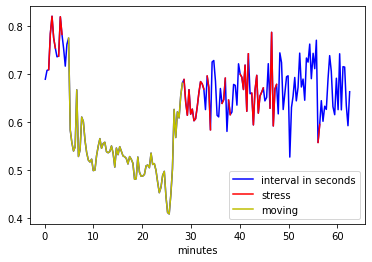

In [12]:
input_df = pd.read_csv('../input/group3/dataset/Vikings/Female_24_years_old/dfnewHRV.csv')
plotFitBitReading(input_df,tpot_classifer,selected_x_columns)